In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display
from matplotlib.widgets import Button, Slider
from ipywidgets import interact, IntSlider

%matplotlib ipympl
from ipywidgets import interact
from mpl_interactions import ipyplot as iplt

import math
from scipy.stats import dirichlet, norm, truncnorm, uniform, expon

from collections import OrderedDict

from trails.mtmc.ml.direct.optimized import log_ml
from trails.mtmc.common import calc_mixed_hypothesis
import trails.transition_probabilities as tp
import trails.randomwalk.randomwalk as rw
import trails.randomwalk.next_state as next_state
import trails.randomwalk.keep_walking as keep_walking
import trails.randomwalk.first_state as first_state
import trails.group_assignment as group_assignment
import trails.mtmc.common as common
import trails.utils as utils
import trails.plot as pl
import trails.mtmc.ml.deterministic.default as deterministic

from metropolis_hastings.mh_algo import metropolis_hastings

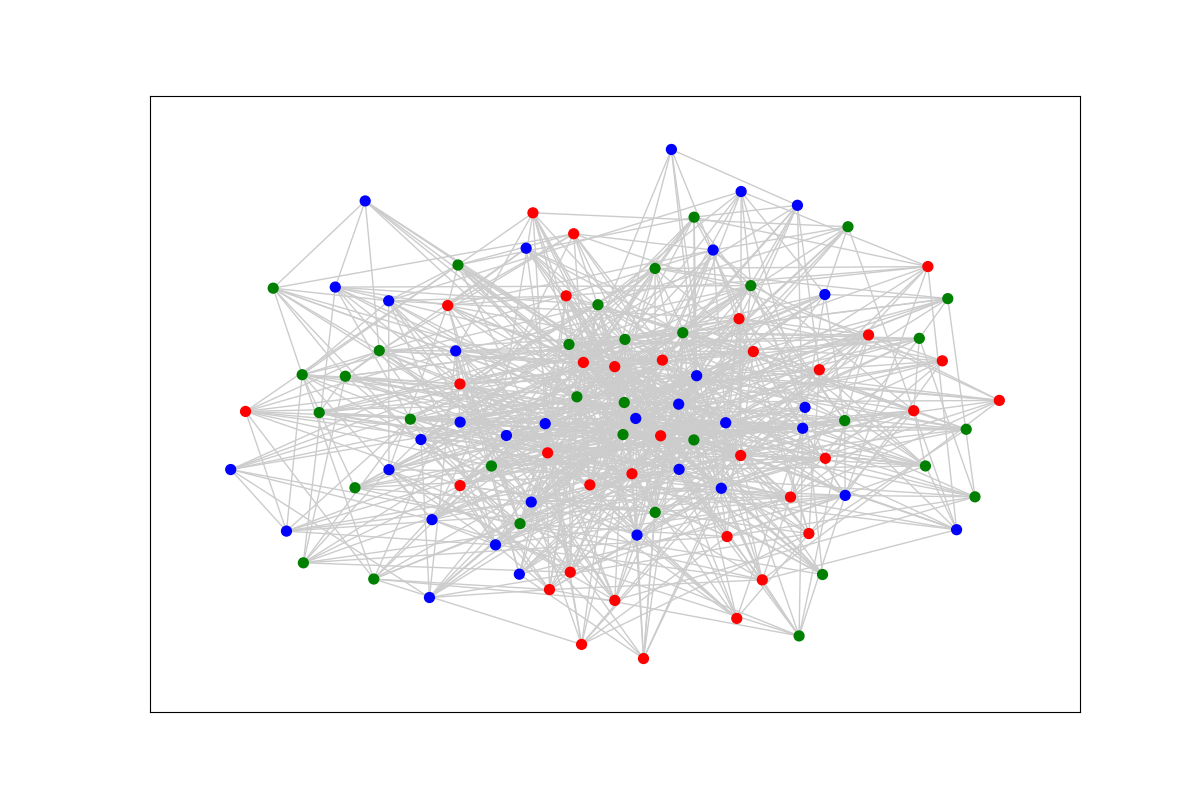

In [12]:
# graph
n_states = 100
p_state_classes = 3 * [1 / 3]
n_state_classes = len(p_state_classes)
graph = nx.barabasi_albert_graph(n_states, int(n_states * 0.10))
adjacency_matrix = np.asarray(nx.to_numpy_array(graph))
state_classes = np.zeros(n_states, dtype=int)
for i in range(n_states):
    state_classes[i] = np.arange(n_state_classes, dtype=int)[np.mod(i, n_state_classes)]


plt.close()
plt.rcParams['figure.figsize'] = 12, 8

# visualize graph

colors=['r', 'b', 'g', 'y', 'm', 'c']
state_colors = []
for i in state_classes:
    state_colors.append(colors[i])

pos=nx.spring_layout(graph)
nodes = nx.draw_networkx_nodes(graph,pos, node_color=state_colors, node_size=50) 
nodes.set_edgecolor(state_colors)
edges = nx.draw_networkx_edges(graph,pos,edge_color="#CCCCCC") 
plt.show()


# hypotheses
tp_group_homo = tp.group_homo(adjacency_matrix, state_classes)
hyp_groups_homo = tp_group_homo
next_homo = next_state.init_grouped_matrix( \
    group_assignment.walker, \
    tp_group_homo)

In [13]:
# transition matrices for walkers

tp_random = tp.random(adjacency_matrix, state_classes)
tp_links = tp.links(adjacency_matrix, state_classes)
tp_group_homo = tp.group_homo(adjacency_matrix, state_classes)
tp_group_homo_weighted = tp.group_homo_weighted(4, adjacency_matrix, state_classes)

# get two more similar transition matrices for the two groups
tp_similar = np.array([tp_group_homo[0], tp_group_homo_weighted[1]])
hyp_similar = tp_similar


# hypotheses (single)

hyp_teleport = utils.norm1_2d(np.ones((n_states, n_states)))
hyp_links = utils.norm1_2d(adjacency_matrix)
hyp_red = utils.norm1_2d(tp_group_homo[0])
hyp_blue = utils.norm1_2d(tp_group_homo[1])

# hypotheses (groups)

hyp_groups_homo = tp_group_homo
hyp_groups_homo_weighted = tp_group_homo_weighted

hyp_groups_memory = np.array([hyp_links, hyp_groups_homo[0], hyp_groups_homo[1]])
hyp_groups_memory_weighted = np.array([hyp_links, hyp_groups_homo_weighted[0], hyp_groups_homo_weighted[1]])

# hypotheses (direct)

number_of_groups = [2,3]
hyp_cart_homo_weighted = tp.expand(hyp_groups_homo_weighted, number_of_groups, 0)
hyp_cart_memory_weighted = tp.expand(hyp_groups_memory_weighted, number_of_groups, 1)

hyp_cart_homo = tp.expand(hyp_groups_homo, number_of_groups, 0)
hyp_cart_memory = tp.expand(hyp_groups_memory, number_of_groups, 1)


# next_step functions for different walker types to determine their next move

next_random = next_state.init_matrix(\
        tp_random)

next_links = next_state.init_matrix(\
        tp_links)

next_homo = next_state.init_grouped_matrix(\
        group_assignment.walker, \
        tp_group_homo)

next_memory = next_state.init_grouped_matrix(\
        group_assignment.memory, \
        [tp_links, tp_group_homo[0], tp_group_homo[1]])

next_homo_weighted = next_state.init_grouped_matrix(\
        group_assignment.walker, \
        tp_group_homo_weighted)

next_memory_weighted = next_state.init_grouped_matrix(\
        group_assignment.memory, \
        [tp_links, tp_group_homo_weighted[0], tp_group_homo_weighted[1], tp_group_homo_weighted[2]])


# violet walkers: we consider violet walkers, where each transition based on the walkers inconsistency
def violet_group(walk, walker, adjacency_matrix, state_properties):
    group = np.random.choice(len(walker), p=walker)
    return group
next_violet = next_state.init_grouped_matrix(violet_group, tp_group_homo_weighted)

next_similar = next_state.init_grouped_matrix(group_assignment.walker, tp_similar)
next_violet_similar = next_state.init_grouped_matrix(violet_group, tp_similar)

In [14]:
# mixed trails specific function to calculate the values for the current state needed to calculate the acceptance ratio
def calc_values(curr_state, smoothing=1, n_samples=10):
    kappa = curr_state[0]
    curr_state = curr_state[1:]
    group_assignment_p_curr = np.repeat(np.array([curr_state]), 100 * n_steps, axis=0)
    alpha_curr = calc_mixed_hypothesis(group_assignment_p_curr, hyp_groups_homo)
    log_likelihood_curr = log_ml(transitions, group_assignment_p_curr, alpha_curr * kappa, smoothing=smoothing, n_samples=n_samples)
    #print(log_likelihood_curr)
    return log_likelihood_curr, prior1.pdf(kappa) * prior2.pdf(curr_state)

# dirichlet proposal distribution
def dirichlet_proposal(curr_state, concentration_factor=100, c2=100):
    curr_kappa = curr_state[0]
    curr_state = curr_state[1:]
    
    #scale = 500
    #proposed_kappa = expon.rvs(scale=curr_kappa)
    #print(proposed_kappa)
    #proposed_kappa = norm.rvs(loc=curr_kappa, scale=scale)
    
    proposed_kappa = uniform.rvs(loc=curr_kappa - np.log(curr_kappa), scale=curr_kappa + 100)
    print(proposed_kappa)
    proposed_state = dirichlet.rvs(alpha=curr_state*concentration_factor, size=1).reshape(len(curr_state))  
    
    # problem: dirichlet samples with zero entries cannot be used as new parameters for the dirichlet proposal dist
    mask = (proposed_state == 0)
    proposed_state[mask] = 0.001
    counts = mask.sum()
    proposed_state[np.argmax(proposed_state)] -= counts * 0.001

    proposal_ratio = (dirichlet.pdf(curr_state, proposed_state * c2) * uniform.pdf(curr_kappa, loc=proposed_kappa - np.log(proposed_kappa) , scale=proposed_kappa + 100)) / (dirichlet.pdf(proposed_state, curr_state * c2) * uniform.pdf(proposed_kappa, loc=curr_kappa - np.log(curr_kappa), scale=curr_kappa + 100))
    #proposal_ratio = (dirichlet.pdf(curr_state, proposed_state * c2) * norm.pdf(curr_kappa, loc=proposed_kappa, scale=scale)) / (dirichlet.pdf(proposed_state, curr_state * c2) * norm.pdf(proposed_kappa, loc=curr_kappa, scale=scale))
    #proposal_ratio = dirichlet.pdf(curr_state, proposed_state * c2) / dirichlet.pdf(proposed_state, curr_state * c2)
    proposed_state = np.concatenate((np.array([proposed_kappa]), proposed_state))
    #print(proposal_ratio)
    #print(proposed_state)
    return proposed_state, proposal_ratio

In [15]:
import trails.mtmc.ml.direct.optimized as directo

kappas_base = [0, 0.001,0.003, 0.01, 0.03, 0.1, 0.3,1,3,10,30,100,300,1000,3000,10000,30000,100000,300000,1000000]

def run_exp(group_assignment_p, hyp, data):
    return {"x": kappas_base, "y": [directo.log_ml(
        transitions = data, 
        group_assignment_p = group_assignment_p, 
        alpha = np.array([a * k for a in hyp]),
        smoothing = 1,
        n_samples = 10) for k in kappas_base]}

def run_exp2(group_assignment_p, hyp, data, kappa):
    return directo.log_ml(
        transitions = data, 
        group_assignment_p = group_assignment_p, 
        alpha = np.array([a * kappa for a in hyp]),
        smoothing = 1,
        n_samples = 10)

# 100 walkers [0.6, 0.3, 0.1] data

In [16]:
# walker data
n_random_walkers = 100
n_steps = 10
p_dist = [0.6, 0.3, 0.1]
n_random_walker_classes = len(p_dist)
random_walker_class_counts = np.random.multinomial(n_random_walkers, p_dist)
random_walker_class_counts = np.array(np.array(p_dist) * n_random_walkers).astype(int)
random_walker_classes = np.repeat(range(n_random_walker_classes), random_walker_class_counts)

r = rw.RandomWalk(adjacency_matrix, state_classes)
walks = r.walk(random_walker_classes, next_homo, keep_walking.init_fixed(n_steps), first_state.random)
transitions = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks])
print(random_walker_class_counts)

[60 30 10]


# Metropolis Hastings

In [17]:
# init prior distribution
  
prior1 = uniform(loc=0, scale=10000)
a = np.array([1, 1, 1])
prior2 = dirichlet(a)
#prior1 = uniform(loc=0, scale= 1000000)

In [18]:
%%time

#kappa = 1000
#init_kappa = np.random.normal(loc=kappa, scale=1)
init_kappa = np.array([10])
init_state = np.random.dirichlet(np.ones(3))
init_state = np.concatenate((init_kappa, init_state))
print(init_state)
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list = metropolis_hastings(init_state, calc_values, 100, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array = np.array(samples)
burnin_samples_array = np.array(burnin_samples)

samples_kappa = samples_array[:, 0]
burnin_samples_kappa = burnin_samples_array[:, 0]

samples_array = samples_array[:, 1:]
burnin_samples_array = burnin_samples_array[:, 1:]

[10.          0.54110997  0.14166101  0.31722902]
39.09837774952379
99.81033404123608
66.85926028336951
43.73214939544183
104.7892365033046
115.57099221989316
72.20815680124836
86.27121555762359


C:\Users\Max\Documents\Master_Würzburg\Hydras\mixed_trails\metropolis_hastings\mh_algo.py:43: RuntimeWarning: overflow encountered in exp
  likelihood_ratio = np.exp(diff)
C:\Users\Max\Documents\Master_Würzburg\Hydras\mixed_trails\metropolis_hastings\mh_algo.py:48: RuntimeWarning: invalid value encountered in scalar multiply
  acceptance_ratio = likelihood_ratio * prior_ratio * proposal_ratio


46.37726609792585
63.600736116736115
28.089366776465983
36.234037800702154
91.69456756711675
107.6079979062695
35.4428737072748
85.11564484732098
25.478937606293503
111.57089418331392
108.63769268817605
105.62820180320449
112.43213404012069
49.51041564409843
79.06860051460187
52.03586654847604
62.64090760231008
98.63202307992924
72.55536147420095
15.253749469712506
104.09333790506737
12.251749193602683
110.8439425978009
121.2305736210589
96.84178979152692
65.2501474526333
22.738529839402666
101.49275351945475
35.408005451737026
100.73803478451026
33.1419338099845
52.516701166067506
37.521281685605146
121.52837271971616
41.14852973176224
107.09482068044427
117.00109504478777
14.407413050524788
113.84094352787486
107.56878600485558
79.84659561059661
108.68135342508178
123.00772465523806
39.50964173903082
60.529548474059595
93.02797655857529
88.46868738794215
19.09050188667827
101.1260853851789
115.11105513662575
63.20910197674426
56.80667770323057
118.39091731038778
126.14372692912524
11

In [19]:
print(burnin_samples_kappa[:100])
print(samples_kappa)

[10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         10.
 10.         10.         10.         10.         10.         12.25174919
 12.25174919 12.25174919 12.25174919 12.25174919 12.25174919 12.25174919
 12.25174919 12.25174919 12.25174919 12.25174919 12.25174919 12.25174919
 12.25174919 12.25174919 12.25174919 14.40741305 14.40741305 14.40741305
 14.40741305 14.40741305]
[14.40741305 14.40741305 14.40741305 14.40741305 14.40741305 14.40741305
 14.40741305 14.40741305 14.40741305 14.40741305 14.40741305 14.40741305
 14.40741305 14.40741305 14.40741305 14.40741305 14.40741305 14.40741305
 14.40741305 14.49508556 14.49508556 14.49508556 14.49508556 14.49508556
 14.49508556 14.49508556 15.73643852 15.73643852 15.73643852 15.73643852
 15.73643852 15.73643852 15.73643852 15.73643852 15.73643

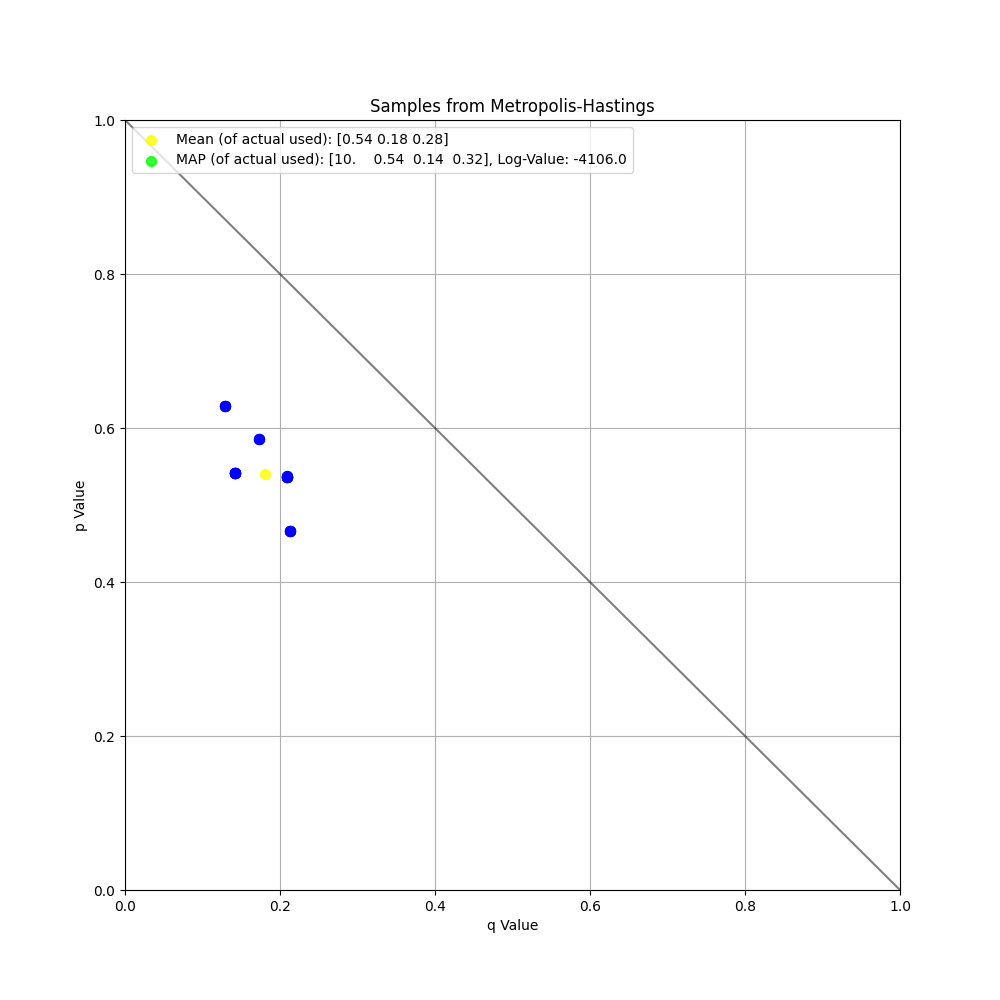

In [20]:
# Function to plot the samples with the specified index
plt.close()
fig1, ax1 = plt.subplots()
fig1.set_size_inches(10, 10)

def plot_sample(sample_index):
    sample_index = int(sample_index)

    samps = np.concatenate((burnin_samples_array, samples_array))
    kappas = np.concatenate((burnin_samples_kappa, samples_kappa))
    
    ax = ax1
    
    ax.cla()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('Samples from Metropolis-Hastings')
    ax.set_xlabel('q Value')
    ax.set_ylabel('p Value')
    ax.grid(True)
    

    ax.scatter(samps[:sample_index, 1], samps[:sample_index, 0], s=50, c='red', alpha=0.3)#, label=f'Sample {sample_index}')
    ax.scatter(samps[sample_index:, 1], samps[sample_index:, 0], s=50, c='blue', alpha=0.3)
    
    curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 2)
    ax.scatter(curr_mean[1], curr_mean[0], s=50, c='yellow', alpha=0.8, label=f'Mean (of actual used): {curr_mean}')

    kappa_mean = np.round(np.mean(kappas[sample_index:]), 2)
    
    
    ax.scatter(map_estimate_list[sample_index][0][1], map_estimate_list[sample_index][0][0], s=50, c='lime', alpha=0.8, 
               label=f'MAP (of actual used): {np.round(map_estimate_list[sample_index][0],2)}, Log-Value: {np.round(map_estimate_list[sample_index][1])}')
    
    ax.legend(loc='upper left', fontsize="10")
    ax.plot([0, 1], [1, 0], transform=ax.transAxes, c='black', alpha=0.5)
    return 0

# Create an interactive plot with slider
iplt.plot(plot_sample, sample_index=(0, len(np.concatenate((burnin_samples_array, samples_array))) - 1))